from funcsigs import signature
from google.cloud import bigquery
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot, matplotlib.ticker, numpy, os, pandas, pyarrow.feather, pyarrow.parquet, itertools, time, warnings

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "bigquery.json"
client = bigquery.Client()

In [4]:
miner_vectors_limit = 6000000
non_miner_vectors_limit = 6000000
'''
miner_vectors_limit = 4800000
non_miner_vectors_limit = 4800000
Time to query live Bitcoin Blockchain: 1589.8354420661926 seconds.
Number of DataFrame Rows: 4810032
Number of DataFrame Columns: 30
memory usage: 1.0+ GB

miner_vectors_limit = 5000000
non_miner_vectors_limit = 5000000
Time to query live Bitcoin Blockchain: 1868.3523926734924 seconds.
Number of DataFrame Rows: 5010032
Number of DataFrame Columns: 30
memory usage: 1.1+ GB
'''

'\nminer_vectors_limit = 4800000\nnon_miner_vectors_limit = 4800000\nTime to query live Bitcoin Blockchain: 1589.8354420661926 seconds.\nNumber of DataFrame Rows: 4810032\nNumber of DataFrame Columns: 30\nmemory usage: 1.0+ GB\n\nminer_vectors_limit = 5000000\nnon_miner_vectors_limit = 5000000\nTime to query live Bitcoin Blockchain: 1868.3523926734924 seconds.\nNumber of DataFrame Rows: 5010032\nNumber of DataFrame Columns: 30\nmemory usage: 1.1+ GB\n'

In [5]:
print("SQL query extracts, transforms, loads bitcoin mining pool address signatures and statistics of their behaviour over time...")
sql_btc_txns = '''
WITH 
output_ages AS (
  SELECT
    ARRAY_TO_STRING(outputs.addresses,',') AS output_ages_address,
    MIN(block_timestamp_month) AS output_month_min,
    MAX(block_timestamp_month) AS output_month_max
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  GROUP BY output_ages_address
)
,input_ages AS (
  SELECT
    ARRAY_TO_STRING(inputs.addresses,',') AS input_ages_address,
    MIN(block_timestamp_month) AS input_month_min,
    MAX(block_timestamp_month) AS input_month_max
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
  GROUP BY input_ages_address
)
,output_monthly_stats AS (
  SELECT
    ARRAY_TO_STRING(outputs.addresses,',') AS output_monthly_stats_address, 
    COUNT(DISTINCT block_timestamp_month) AS output_active_months,
    COUNT(outputs) AS total_tx_output_count,
    SUM(value) AS total_tx_output_value,
    AVG(value) AS mean_tx_output_value,
    STDDEV(value) AS stddev_tx_output_value,
    COUNT(DISTINCT(`hash`)) AS total_output_tx,
    SUM(value)/COUNT(block_timestamp_month) AS mean_monthly_output_value,
    COUNT(outputs.addresses)/COUNT(block_timestamp_month) AS mean_monthly_output_count
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  GROUP BY output_monthly_stats_address
)
,input_monthly_stats AS (
  SELECT
    ARRAY_TO_STRING(inputs.addresses,',') AS input_monthly_stats_address, 
    COUNT(DISTINCT block_timestamp_month) AS input_active_months,
    COUNT(inputs) AS total_tx_input_count,
    SUM(value) AS total_tx_input_value,
    AVG(value) AS mean_tx_input_value,
    STDDEV(value) AS stddev_tx_input_value,
    COUNT(DISTINCT(`hash`)) AS total_input_tx,
    SUM(value)/COUNT(block_timestamp_month) AS mean_monthly_input_value,
    COUNT(inputs.addresses)/COUNT(block_timestamp_month) AS mean_monthly_input_count
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
  GROUP BY input_monthly_stats_address
)
,output_idle_times AS (
  SELECT
    address AS idle_time_address,
    AVG(idle_time) AS mean_output_idle_time,
    STDDEV(idle_time) AS stddev_output_idle_time
  FROM
  (
    SELECT 
      event.address,
      IF(prev_block_time IS NULL, NULL, UNIX_SECONDS(block_time) - UNIX_SECONDS(prev_block_time)) AS idle_time
    FROM (
      SELECT
        ARRAY_TO_STRING(outputs.addresses,',') AS address, 
        block_timestamp AS block_time,
        LAG(block_timestamp) OVER (PARTITION BY ARRAY_TO_STRING(outputs.addresses,',') ORDER BY block_timestamp) AS prev_block_time
      FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
    ) AS event
    WHERE block_time != prev_block_time
  )
  GROUP BY address
)
,input_idle_times AS (
  SELECT
    address AS idle_time_address,
    AVG(idle_time) AS mean_input_idle_time,
    STDDEV(idle_time) AS stddev_input_idle_time
  FROM
  (
    SELECT 
      event.address,
      IF(prev_block_time IS NULL, NULL, UNIX_SECONDS(block_time) - UNIX_SECONDS(prev_block_time)) AS idle_time
    FROM (
      SELECT
        ARRAY_TO_STRING(inputs.addresses,',') AS address, 
        block_timestamp AS block_time,
        LAG(block_timestamp) OVER (PARTITION BY ARRAY_TO_STRING(inputs.addresses,',') ORDER BY block_timestamp) AS prev_block_time
      FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
    ) AS event
    WHERE block_time != prev_block_time
  )
  GROUP BY address
)
--,miners AS (
--)

(SELECT
  TRUE AS is_miner,
  output_ages_address AS address,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_month_min,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) AS output_month_max,
  UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_month_min,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS input_month_max,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_active_time,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_active_time,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS io_max_lag,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS io_min_lag,
  output_monthly_stats.output_active_months,
  output_monthly_stats.total_tx_output_count,
  output_monthly_stats.total_tx_output_value,
  output_monthly_stats.mean_tx_output_value,
  output_monthly_stats.stddev_tx_output_value,
  output_monthly_stats.total_output_tx,
  output_monthly_stats.mean_monthly_output_value,
  output_monthly_stats.mean_monthly_output_count,
  input_monthly_stats.input_active_months,
  input_monthly_stats.total_tx_input_count,
  input_monthly_stats.total_tx_input_value,
  input_monthly_stats.mean_tx_input_value,
  input_monthly_stats.stddev_tx_input_value,
  input_monthly_stats.total_input_tx,
  input_monthly_stats.mean_monthly_input_value,
  input_monthly_stats.mean_monthly_input_count,
  output_idle_times.mean_output_idle_time,
  output_idle_times.stddev_output_idle_time,
  input_idle_times.mean_input_idle_time,
  input_idle_times.stddev_input_idle_time
FROM
  output_ages, output_monthly_stats, output_idle_times,
  input_ages,  input_monthly_stats, input_idle_times
WHERE TRUE
  AND output_ages.output_ages_address = output_monthly_stats.output_monthly_stats_address
  AND output_ages.output_ages_address = output_idle_times.idle_time_address
  AND output_ages.output_ages_address = input_monthly_stats.input_monthly_stats_address
  AND output_ages.output_ages_address = input_ages.input_ages_address
  AND output_ages.output_ages_address = input_idle_times.idle_time_address
  AND output_ages.output_ages_address IN
(
  SELECT 
    ARRAY_TO_STRING(outputs.addresses,',') AS miner
  FROM 
  `bigquery-public-data.crypto_bitcoin.blocks` AS blocks,
  `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  WHERE blocks.hash = transactions.block_hash 
    AND is_coinbase IS TRUE
    AND ( FALSE
      --
      -- miner signatures from https://en.bitcoin.it/wiki/Comparison_of_mining_pools
      --
      OR coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' --AntPool
      OR coinbase_param LIKE '%2f42434d6f6e737465722f%' --BCMonster
      --BitcoinAffiliateNetwork
      OR coinbase_param LIKE '%4269744d696e746572%' --BitMinter
      --BTC.com
      --BTCC Pool
      --BTCDig
      OR coinbase_param LIKE '%2f7374726174756d2f%' --Btcmp
      --btcZPool.com
      --BW Mining
      OR coinbase_param LIKE '%456c6967697573%' --Eligius
      --F2Pool
      --GHash.IO
      --Give Me COINS
      --Golden Nonce Pool
      OR coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' --Bravo Mining
      OR coinbase_param LIKE '%4b616e6f%' --KanoPool
      --kmdPool.org
      OR coinbase_param LIKE '%2f6d6d706f6f6c%' --Merge Mining Pool
      --MergeMining
      --Multipool
      --P2Pool
      OR coinbase_param LIKE '%2f736c7573682f%' --Slush Pool
      --ZenPool.org
    )
  GROUP BY miner
  HAVING COUNT(1) >= 20 
)
LIMIT {})
UNION ALL
(SELECT
  FALSE AS is_miner,
  output_ages_address AS address,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_month_min,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) AS output_month_max,
  UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_month_min,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS input_month_max,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_active_time,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_active_time,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS io_max_lag,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS io_min_lag,
  output_monthly_stats.output_active_months,
  output_monthly_stats.total_tx_output_count,
  output_monthly_stats.total_tx_output_value,
  output_monthly_stats.mean_tx_output_value,
  output_monthly_stats.stddev_tx_output_value,
  output_monthly_stats.total_output_tx,
  output_monthly_stats.mean_monthly_output_value,
  output_monthly_stats.mean_monthly_output_count,
  input_monthly_stats.input_active_months,
  input_monthly_stats.total_tx_input_count,
  input_monthly_stats.total_tx_input_value,
  input_monthly_stats.mean_tx_input_value,
  input_monthly_stats.stddev_tx_input_value,
  input_monthly_stats.total_input_tx,
  input_monthly_stats.mean_monthly_input_value,
  input_monthly_stats.mean_monthly_input_count,
  output_idle_times.mean_output_idle_time,
  output_idle_times.stddev_output_idle_time,
  input_idle_times.mean_input_idle_time,
  input_idle_times.stddev_input_idle_time
FROM
  output_ages, output_monthly_stats, output_idle_times,
  input_ages,  input_monthly_stats, input_idle_times
WHERE TRUE
  AND output_ages.output_ages_address = output_monthly_stats.output_monthly_stats_address
  AND output_ages.output_ages_address = output_idle_times.idle_time_address
  AND output_ages.output_ages_address = input_monthly_stats.input_monthly_stats_address
  AND output_ages.output_ages_address = input_ages.input_ages_address
  AND output_ages.output_ages_address = input_idle_times.idle_time_address
  AND output_ages.output_ages_address NOT IN
(
  SELECT 
    ARRAY_TO_STRING(outputs.addresses,',') AS miner
  FROM 
  `bigquery-public-data.crypto_bitcoin.blocks` AS blocks,
  `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  WHERE blocks.hash = transactions.block_hash 
    AND is_coinbase IS TRUE
    AND ( FALSE
      --
      -- miner signatures from https://en.bitcoin.it/wiki/Comparison_of_mining_pools
      --
      OR coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' --AntPool
      OR coinbase_param LIKE '%2f42434d6f6e737465722f%' --BCMonster
      --BitcoinAffiliateNetwork
      OR coinbase_param LIKE '%4269744d696e746572%' --BitMinter
      --BTC.com
      --BTCC Pool
      --BTCDig
      OR coinbase_param LIKE '%2f7374726174756d2f%' --Btcmp
      --btcZPool.com
      --BW Mining
      OR coinbase_param LIKE '%456c6967697573%' --Eligius
      --F2Pool
      --GHash.IO
      --Give Me COINS
      --Golden Nonce Pool
      OR coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' --Bravo Mining
      OR coinbase_param LIKE '%4b616e6f%' --KanoPool
      --kmdPool.org
      OR coinbase_param LIKE '%2f6d6d706f6f6c%' --Merge Mining Pool
      --MergeMining
      --Multipool
      --P2Pool
      OR coinbase_param LIKE '%2f736c7573682f%' --Slush Pool
      --ZenPool.org
    )
  GROUP BY miner
  HAVING COUNT(1) >= 20 
)
LIMIT {})
'''.format(miner_vectors_limit, non_miner_vectors_limit)

SQL query extracts, transforms, loads bitcoin mining pool address signatures and statistics of their behaviour over time...


In [6]:
start_time = time.time()
df = client.query(sql_btc_txns).to_dataframe()
query_duration = time.time() - start_time
print(f"Time to query live Bitcoin Blockchain: {query_duration} seconds.")
print(f"Number of DataFrame Rows: {len(df.index)}")
print(f"Number of DataFrame Columns: {len(df.columns)}")

/usr/local/lib/python3.8/dist-packages/google/cloud/bigquery/client.py:406: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


Time to query live Bitcoin Blockchain: 1677.61119389534 seconds.
Number of DataFrame Rows: 6010032
Number of DataFrame Columns: 30


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6010032 entries, 0 to 6010031
Data columns (total 30 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   is_miner                   bool   
 1   address                    object 
 2   output_month_min           int64  
 3   output_month_max           int64  
 4   input_month_min            int64  
 5   input_month_max            int64  
 6   output_active_time         int64  
 7   input_active_time          int64  
 8   io_max_lag                 int64  
 9   io_min_lag                 int64  
 10  output_active_months       int64  
 11  total_tx_output_count      int64  
 12  total_tx_output_value      object 
 13  mean_tx_output_value       object 
 14  stddev_tx_output_value     float64
 15  total_output_tx            int64  
 16  mean_monthly_output_value  object 
 17  mean_monthly_output_count  float64
 18  input_active_months        int64  
 19  total_tx_input_count       int64  
 20  to

### Benchmarking Disk Read/Write Speed with Pandas Binary Formats

When the number of observations in your dataset is high, the process of saving and loading data back into the memory becomes slower, and each kernel’s restart steals time and forces you to wait until the data reloads _(as seen by the **Time to query** variable above)._

There are plenty of panda-supported binary formats to store the data on disk. 

**We go through several methods to save and load pandas.DataFrame onto disk and see which one is best in terms of I/O speed...**

Source: https://tinyurl.com/y5kbyfj2

In [58]:
print("Parquet is a standard storage format for analytics that is supported by AWS, BigQuery, Impala, Hive & Spark and is designed for long-term storage with layers of encoding and compression\n")

print('bitcoin2_parquet:')
%timeit pyarrow.parquet.write_table(pyarrow.Table.from_pandas(df), 'bitcoin2.parquet')

print('bitcoin2_parquet:')
%timeit pyarrow.parquet.read_table('bitcoin2.parquet', use_threads = True).to_pandas() # parallelize data read from disk using multiple threads.

Parquet is a standard storage format for analytics that is supported by AWS, BigQuery, Impala, Hive & Spark and is designed for long-term storage with layers of encoding and compression

bitcoin2_parquet:
1min 8s ± 1.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
bitcoin2_parquet:
1min 30s ± 769 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
print("Feather is a binary data format for quick loading and transformation which enables faster I/O speeds and less memory and with which data frames can be exchanged between Python and R\n")

print('bitcoin2_feather:')
%timeit pyarrow.feather.write_feather(df, 'bitcoin2_feather')

print('bitcoin2_feather:')
%timeit pyarrow.feather.read_feather('bitcoin2_feather', use_threads = True) # parallelize data read from disk using multiple threads.

Feather is a binary data format for quick loading and transformation which enables faster I/O speeds and less memory and with which data frames can be exchanged between Python and R

bitcoin2_feather:
1min 4s ± 2.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
bitcoin2_feather:
1min 28s ± 1.89 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
warnings.filterwarnings('ignore',category = pandas.io.pytables.PerformanceWarning)

print("HDF5 is a standard for storing huge volumens of multi-dimensional data in hierarchical groups with the root group on top just like the UNIX file system\n")

print('bitcoin_hdf:')
%timeit df.to_hdf('bitcoin_hdf', 'key_to_store', mode = 'w', table = False)

# print('example_hdf:')
# %timeit pandas.read_hdf('bitcoin_hdf')

HDF5 is a standard for storing huge volumens of multi-dimensional data in hierarchical groups with the root group on top just like the UNIX file system

bitcoin_hdf:


TypeError: to_hdf() got an unexpected keyword argument 'table'

In [12]:
print("Pickles are primarily used in serializing and deserializing Python object structures from bytestreams to act as file or database storage, maintain program state across sessions, or transport data over the network\n")

print('bitcoin_pickle_protocol_2:')
%timeit df.to_pickle('bitcoin_pickle_protocol_2', protocol =2)

print('bitcoin_pickle_protocol_2:')
%timeit pandas.read_pickle('bitcoin_pickle_protocol_2')

Pickles are primarily used in serializing and deserializing Python object structures from bytestreams to act as file or database storage, maintain program state across sessions, or transport data over the network

bitcoin_pickle_protocol_2:
1min 6s ± 3.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
bitcoin_pickle_protocol_2:
19.4 s ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
unpickled_dataframe = pandas.read_pickle("example_pickle")
unpickled_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410032 entries, 0 to 5410031
Data columns (total 30 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   is_miner                   bool   
 1   address                    object 
 2   output_month_min           int64  
 3   output_month_max           int64  
 4   input_month_min            int64  
 5   input_month_max            int64  
 6   output_active_time         int64  
 7   input_active_time          int64  
 8   io_max_lag                 int64  
 9   io_min_lag                 int64  
 10  output_active_months       int64  
 11  total_tx_output_count      int64  
 12  total_tx_output_value      object 
 13  mean_tx_output_value       object 
 14  stddev_tx_output_value     float64
 15  total_output_tx            int64  
 16  mean_monthly_output_value  object 
 17  mean_monthly_output_count  float64
 18  input_active_months        int64  
 19  total_tx_input_count       int64  
 20  to

Cleaning data to drop columns that contain features with null values

In [14]:
unpickled_dataframe.drop(labels = ['stddev_output_idle_time','stddev_input_idle_time'], axis = 1, inplace = True)

In [15]:
unpickled_dataframe.head(5)

,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
0,False,1MnvtVRaoY4dTimq339orVxXj7w4fR8gjw,1501545600,1541030400,1501545600,1541030400,39484800,39484800,0,0,...,8,42,19069707550.000000000,454040655.952380952,5.875064e+08,40,454040655.952380952,1.0,1.161160e+06,1.041992e+06
1,False,3LQsGxNQatdzAgWAVDTNQkzyG2s1NYAAKx,1556668800,1559347200,1556668800,1559347200,2678400,2678400,0,0,...,2,17,34130200.000000000,2007658.823529412,3.668853e+06,17,2007658.823529412,1.0,1.845218e+05,2.260233e+05
2,False,3PoSmWuxwUdVL75wxEz9r7Sw1TXE2UTcHF,1577836800,1593561600,1577836800,1593561600,15724800,15724800,0,0,...,4,22,17557978.000000000,798089.909090909,3.110418e+05,22,798089.909090909,1.0,7.529924e+05,7.529553e+05
3,False,3AsMay2zohhd79ky89T79qe88t1mB8RFcb,1535760000,1577836800,1535760000,1583020800,42076800,47260800,-5184000,0,...,19,922,318852119.000000000,345826.593275488,7.453159e+05,627,345826.593275488,1.0,4.718330e+04,9.834612e+04
4,False,bc1qanc7cnyxu2rnqwjpfq6lp76fr5tn8ujgp5ctcw,1575158400,1593561600,1577836800,1593561600,18403200,15724800,0,-2678400,...,7,24,12629582.000000000,526232.583333333,1.996834e+04,18,526232.583333333,1.0,8.222581e+05,8.944998e+05


In [16]:
unpickled_dataframe.tail(5)

,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
5410027,False,1LFUkT6cc42NyHEWz985R742yb6UvQuWep,1575158400,1585699200,1575158400,1585699200,10540800,10540800,0,0,...,5,19,34659400.000000000,1824178.947368421,2.575641e+06,14,1824178.947368421,1.0,4.963660e+05,7.874838e+05
5410028,False,39t6JNrntZ1KUcDSEcQqu2Fshf8P5yGYPX,1580515200,1593561600,1585699200,1596240000,13046400,10540800,-2678400,-5184000,...,3,19,18869619.000000000,993137.842105263,1.353353e+06,3,993137.842105263,1.0,7.231419e+05,4.096154e+06
5410029,False,1NCcd6AyoigD6o5E7Qv6Zd52CDBqUt6WY9,1593561600,1596240000,1593561600,1596240000,2678400,2678400,0,0,...,2,19,1102791.000000000,58041.631578947,1.312936e+04,7,58041.631578947,1.0,7.493485e+04,1.680068e+05
5410030,False,114qX87btSEnMcmNG9a8vfHagzGT4YJeb,1512086400,1564617600,1512086400,1564617600,52531200,52531200,0,0,...,6,19,192791339.000000000,10146912.578947368,1.203622e+07,19,10146912.578947368,1.0,2.943274e+06,2.943728e+06
5410031,False,18n3uTizDjq4qF1oR9WAFM4fafoUoDjC3j,1480550400,1509494400,1480550400,1514764800,28944000,34214400,-5270400,0,...,4,19,24870955.000000000,1308997.631578947,5.427828e+05,5,1308997.631578947,1.0,1.677838e+06,8.287532e+06


Removing columns with non-numerical features from x variables

In [17]:
X = unpickled_dataframe.drop(labels = ['is_miner','address'], axis = 1)

Setting 'is_miner' as the target y variable

In [18]:
y = unpickled_dataframe['is_miner'].values

Row numbers identify which data points are selected in the training and test se

In [19]:
row_number = range(len(X))
print(f"Number of Rows: {row_number}\n")

Number of Rows: range(0, 5410032)



Splitting input data into training and testing sets

In [20]:
X_train, X_test, y_train, y_test, row_number_train, row_number_test = train_test_split(X, y, row_number, test_size = 0.2)

In [21]:
(X_train).head(2)

,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,output_active_months,total_tx_output_count,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
2445149,1512086400,1512086400,1512086400,1514764800,0,2678400,-2678400,0,1,3,...,2,3,831334.000000000,277111.333333333,254016.658779,3,277111.333333333,1.0,480775.0,116769.5
709571,1556668800,1556668800,1556668800,1556668800,0,0,0,0,1,2,...,1,2,2225412.000000000,1112706.000000000,4683.875319,2,1112706.000000000,1.0,20974.0,23245.0


In [22]:
(X_test).head(2)

,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,output_active_months,total_tx_output_count,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
4897121,1398902400,1470009600,1433116800,1477958400,71107200,44841600,-7948800,-34214400,21,68,...,3,68,1158320.000000000,17034.117647059,10174.859032,3,17034.117647059,1.0,1.083282e+06,2.176029e+07
4670965,1483228800,1485907200,1496275200,1498867200,2678400,2592000,-12960000,-13046400,2,4,...,2,4,470000.000000000,117500.000000000,59090.326337,4,117500.000000000,1.0,4.151570e+05,4.309563e+05


**Random Forest Hyperparameters**
* Training the random forest classification model on the training set
* Running model jobs in parallel using all the processors available with n_jobs
* Entropy chosen as criterion to measure quality of splits by information gain
* 200 trees used in random forest for sufficient accuracy

In [24]:
%load_ext memory_profiler
rf_classifier_max_cpus = RandomForestClassifier(n_jobs = -1, criterion = 'entropy', n_estimators = 200)
start_time_max = time.time()
%memit rf_classifier_max_cpus.fit(X_train, y_train)
random_forest_max_cpus_duration = time.time() - start_time_max
print(f"Random Forest Classification Max CPUs: {random_forest_max_cpus_duration} seconds")

peak memory: 20219.86 MiB, increment: 2505.56 MiB
Random Forest Classification Max CPUs: 376.46727538108826 seconds


Make predictions (y_pred) from our test features (X_test) using our Random Forest model

In [25]:
y_pred = rf_classifier_max_cpus.predict(X_test)
y_pred

array([False, False, False, ..., False, False, False])

Predicts the Probability of each row belonging to a Mining Pool (true)...

In [26]:
positive_class_probabilities = rf_classifier_max_cpus.predict_proba(X_test)[:,1]
positive_class_probabilities

array([0., 0., 0., ..., 0., 0., 0.])

#### Optimising Model Persistence (Pickle vs. JobLib)

In [27]:
rf_classifier_8_cpus = RandomForestClassifier(n_jobs = 8, criterion = 'entropy', n_estimators = 200)
start_time = time.time()
%memit rf_classifier_8_cpus.fit(X_train, y_train)
random_forest_8_cpus_duration = time.time() - start_time
print(f"Random Forest Classification 8 CPUs: {random_forest_8_cpus_duration} seconds")

peak memory: 20396.75 MiB, increment: 2277.12 MiB
Random Forest Classification 8 CPUs: 365.0432255268097 seconds


In [31]:
from joblib import dump, load
dump(rf_classifier_8_cpus, 'model_rf_8_cpu.joblib')

['model_rf_8_cpu.joblib']

### Optimizing Random Forest Model Training with Multiple Cores (Memory vs Duration)

In [32]:
rf_classifier_7_cpus = RandomForestClassifier(n_jobs = 7, criterion = 'entropy', n_estimators = 200)
start_time_7_cpus = time.time()
%memit rf_classifier_7_cpus.fit(X_train, y_train)
random_forest_7_cpus_duration = time.time() - start_time_7_cpus
print(f"Random Forest Classification 7 CPUs: {random_forest_7_cpus_duration} seconds")

peak memory: 20291.38 MiB, increment: 2168.45 MiB
Random Forest Classification 7 CPUs: 338.7181544303894 seconds


In [33]:
rf_classifier_6_cpus = RandomForestClassifier(n_jobs = 6, criterion = 'entropy', n_estimators = 200)
start_time_6_cpu = time.time()
%memit rf_classifier_6_cpus.fit(X_train, y_train)
random_forest_6_cpus_duration = time.time() - start_time_6_cpu
print(f"Random Forest Classification 6 CPUs: {random_forest_6_cpus_duration} seconds")

peak memory: 20040.06 MiB, increment: 1829.82 MiB
Random Forest Classification 6 CPUs: 404.746701002121 seconds


In [34]:
rf_classifier_5_cpus = RandomForestClassifier(n_jobs = 5, criterion = 'entropy', n_estimators = 200)
start_time_5_cpus = time.time()
%memit rf_classifier_5_cpus.fit(X_train, y_train)
random_forest_5_cpus_duration = time.time() - start_time_5_cpus
print(f"Random Forest Classification 5 CPUs: {random_forest_5_cpus_duration} seconds")

peak memory: 19920.57 MiB, increment: 1612.38 MiB
Random Forest Classification 5 CPUs: 422.2468008995056 seconds


In [35]:
rf_classifier_4_cpus = RandomForestClassifier(n_jobs = 4, criterion = 'entropy', n_estimators = 200)
start_time_4_cpu = time.time()
%memit rf_classifier_4_cpus.fit(X_train, y_train)
random_forest_4_cpus_duration = time.time() - start_time_4_cpu
print(f"Random Forest Classification 4 CPUs: {random_forest_4_cpus_duration} seconds")

peak memory: 19912.38 MiB, increment: 1518.85 MiB
Random Forest Classification 4 CPUs: 450.6845819950104 seconds


In [36]:
rf_classifier_3_cpus = RandomForestClassifier(n_jobs = 3, criterion = 'entropy', n_estimators = 200)
start_time_3_cpus = time.time()
%memit rf_classifier_3_cpus.fit(X_train, y_train)
random_forest_3_cpus_duration = time.time() - start_time_3_cpus
print(f"Random Forest Classification 3 CPUs: {random_forest_3_cpus_duration} seconds")

peak memory: 19998.07 MiB, increment: 1518.81 MiB
Random Forest Classification 3 CPUs: 558.6772050857544 seconds


In [37]:
rf_classifier_2_cpus = RandomForestClassifier(n_jobs = 2, criterion = 'entropy', n_estimators = 200)
start_time_2_cpu = time.time()
%memit rf_classifier_2_cpus.fit(X_train, y_train)
random_forest_2_cpus_duration = time.time() - start_time_2_cpu
print(f"Random Forest Classification 2 CPUs: {random_forest_2_cpus_duration} seconds")

peak memory: 20098.04 MiB, increment: 1518.81 MiB
Random Forest Classification 2 CPUs: 808.5329873561859 seconds


In [38]:
rf_classifier_1_cpu = RandomForestClassifier(n_jobs = 1, criterion = 'entropy', n_estimators = 200)
start_time_1_cpu = time.time()
%memit rf_classifier_1_cpu.fit(X_train, y_train)
random_forest_1_cpu_duration = time.time() - start_time_1_cpu
print(f"Random Forest Classification 1 CPU: {random_forest_1_cpu_duration} seconds")

peak memory: 20199.30 MiB, increment: 1518.91 MiB
Random Forest Classification 1 CPU: 1554.3387501239777 seconds


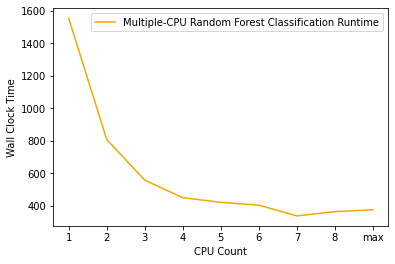

In [39]:
cpu_count = [1, 2, 3, 4, 5, 6, 7, 8, 'max']
times_elapsed = [random_forest_1_cpu_duration, random_forest_2_cpus_duration, random_forest_3_cpus_duration, random_forest_4_cpus_duration, random_forest_5_cpus_duration, random_forest_6_cpus_duration, random_forest_7_cpus_duration, random_forest_8_cpus_duration, random_forest_max_cpus_duration]
matplotlib.pyplot.plot(cpu_count, times_elapsed, color = '#f2a900', label = 'Multiple-CPU Random Forest Classification Runtime')
matplotlib.pyplot.legend()
matplotlib.pyplot.xlabel('CPU Count')
matplotlib.pyplot.ylabel('Wall Clock Time')
matplotlib.pyplot.savefig('cpu_count_v_rf_runtime')

### How good is our Model?

#### Precision-Recall Tradeoff

**High precision** relates to a low false positive rate

**High recall** relates to a low false negative rate 

##### An ideal system with high precision and high recall will return many results, with all results labeled correctly

######  Note:
* _A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels_ 

* _A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels_

Source: https://tinyurl.com/yxbjk26m

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, positive_class_probabilities)


The color = #f2a900 parameter ensures the plotline is bitcoin orange

The alpha = 1 parameter makes the plotline 100% opaque vs. the area under the curve alpha = 0.4 i.e. 40% opaque

The where = post parameter ensures y-values are continued constantly to the right from every x-position



Text(0.5, 0.01, 'In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned')

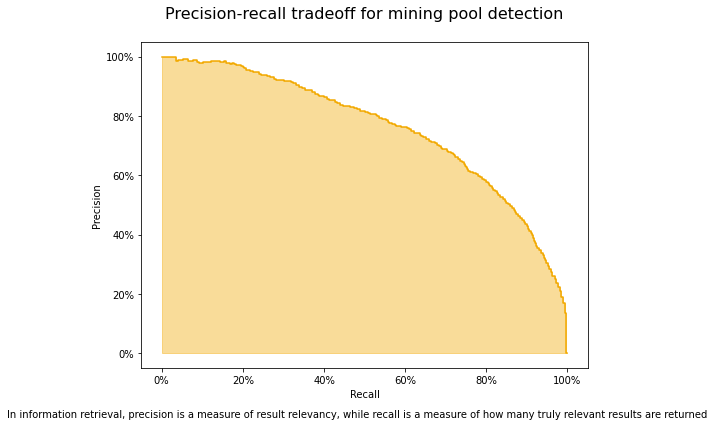

In [41]:
figure, axis = matplotlib.pyplot.subplots(figsize = (8, 6))
step_kwargs = ({'step': 'post'}
               if 'step' in signature(matplotlib.pyplot.fill_between).parameters
               else {})

print("\nThe color = #f2a900 parameter ensures the plotline is bitcoin orange\n")
print("The alpha = 1 parameter makes the plotline 100% opaque vs. the area under the curve alpha = 0.4 i.e. 40% opaque\n")
print("The where = post parameter ensures y-values are continued constantly to the right from every x-position\n")

matplotlib.pyplot.step(recall, precision, color = '#f2a900', alpha = 1, where = 'post')
matplotlib.pyplot.fill_between(recall, precision, alpha = 0.4, color = '#f2a900', **step_kwargs)
matplotlib.pyplot.xlabel('Recall')
matplotlib.pyplot.ylabel('Precision')
matplotlib.pyplot.title('Precision-recall tradeoff for mining pool detection\n', fontsize = 16)
axis.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
axis.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
caption = "In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned"
figure.text(.5, .01, caption, ha = 'center')

#### Confusion Matrix Computation

A confusion matrix is a 2x2 table used to **visualize the learning performance** of a supervised classification algorithm (Random Forest) on a set of test data for which the true values are known

Source: https://tinyurl.com/yypv62js

In [42]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = matplotlib.pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    dummy = numpy.array([[0, 0],[0, 0]])
    matplotlib.pyplot.figure(figsize = (8,6))
    matplotlib.pyplot.imshow(dummy, interpolation = 'nearest', cmap = cmap)
    matplotlib.pyplot.title(title)
    tick_marks = numpy.arange(len(classes))
    matplotlib.pyplot.xticks(tick_marks, classes, rotation = 45)
    matplotlib.pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "black")

    matplotlib.pyplot.ylabel('True label')
    matplotlib.pyplot.xlabel('Predicted label')
    matplotlib.pyplot.tight_layout()
    
    # Source: https://tinyurl.com/yyn7tpah

### How good is our Model?
#### Precision-Recall Tradeoff
_Objective: Predict the Probability of each row belonging to a Mining Pool_
* **High precision** relates to a low false positive rate

* **High recall** relates to a low false negative rate 

##### An ideal system with high precision and high recall will return many results, with all results labeled correctly

######  Note:
* _A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels_ 

* _A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels_

Source: https://tinyurl.com/yxbjk26m

#### Function to plot Precision-Recall Curve

**_matplotlib.pyplot.step_ parameters:**

* The color = #f2a900 parameter ensures the plotline is bitcoin orange
* The alpha = 1 parameter makes the plotline 100% opaque vs. the area under the curve alpha = 0.4 i.e. 40% opaque
* The where = post parameter ensures y-values are continued constantly to the right from every x-position


In [43]:
def plot_precision_recall_tradeoff(_precision, _recall):
    figure, axis = matplotlib.pyplot.subplots(figsize = (8, 6))
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(matplotlib.pyplot.fill_between).parameters
               else {})
    
    matplotlib.pyplot.step(_recall, _precision, color = '#f2a900', alpha = 1, where = 'post')
    matplotlib.pyplot.fill_between(_recall, _precision, alpha = 0.4, color = '#f2a900', **step_kwargs)
    matplotlib.pyplot.xlabel('Recall')
    matplotlib.pyplot.ylabel('Precision')
    matplotlib.pyplot.title('Precision-recall tradeoff for mining pool detection\n', fontsize = 16)
    axis.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    axis.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    caption = "In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned"
    figure.text(.5, .01, caption, ha = 'center')

array([0., 0., 0., ..., 0., 0., 0.])

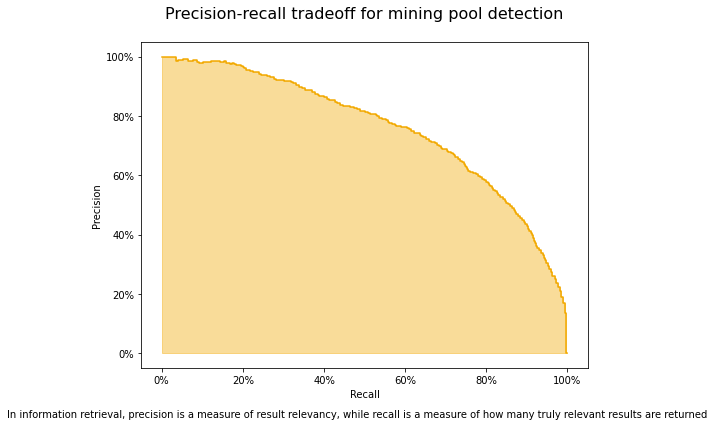

In [44]:
positive_class_probabilities_rf_max_cpus = rf_classifier_max_cpus.predict_proba(X_test)[:,1]
precision_rf_max, recall_rf_max, thresholds_rf_max = precision_recall_curve(y_test, positive_class_probabilities_rf_max_cpus)
plot_precision_recall_tradeoff(precision_rf_max, recall_rf_max)
positive_class_probabilities_rf_max_cpus

#### Predicting whether Mining Pool vs Non Mining Pool (y-pred)

Make predictions (y_pred) from our test features (X_test) using our Random Forest model (8-CPU version)

In [45]:
y_pred_rf_max_cpus = rf_classifier_max_cpus.predict(X_test)
y_pred_rf_max_cpus

array([False, False, False, ..., False, False, False])

#### Confusion Matrix Computation

A confusion matrix is a 2x2 table used to **visualize the learning performance** of a supervised classification algorithm (Random Forest) on a set of test data for which the true values are known

Source: https://tinyurl.com/yypv62js

In [46]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix\n', cmap = matplotlib.pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    dummy = numpy.array([[0, 0], [0, 0]])
    matplotlib.pyplot.figure(figsize = (8, 6))
    matplotlib.pyplot.imshow(dummy, interpolation = 'nearest', cmap = cmap)
    matplotlib.pyplot.title(title)
    tick_marks = numpy.arange(len(classes))
    matplotlib.pyplot.xticks(tick_marks, classes, rotation = 45)
    matplotlib.pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        matplotlib.pyplot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "black")

    matplotlib.pyplot.ylabel('Actual Label')
    matplotlib.pyplot.xlabel('Predicted Classification')
    matplotlib.pyplot.tight_layout()

Confusion Matrix Plot Source: https://tinyurl.com/yyn7tpah

#### Function to plot Precision-Recall Curve

Confusion matrix, without normalization
[[1079779     264]
 [    912    1052]]


<Figure size 432x288 with 0 Axes>

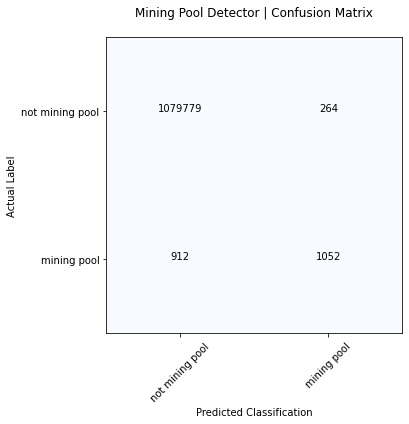

In [47]:
cnf_matrix = confusion_matrix(y_test, y_pred_rf_max_cpus)
class_names = ['not mining pool', 'mining pool']
numpy.set_printoptions(precision = 2)
matplotlib.pyplot.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Mining Pool Detector | Confusion Matrix\n')

### Best Mining Pool Indicator 

Which features _(in the bitcoin transaction)_ best indicate whether it will be mined by a publicly known mining pool (provide the most signal)?

#### How many features to plot?
Let's visualize the importance of the top 10 X variables within a Bitcoin transaction that contribute to the mining pool prediction

In [48]:
def plot_feature_importance(_input_features, _x_pos):
    matplotlib.pyplot.figure(figsize = (12, 6))
    matplotlib.pyplot.barh(_x_pos, _input_features, bar_width, label = 'BTC model')
    matplotlib.pyplot.yticks(x_pos, cols, rotation = 0, fontsize = 14)
    matplotlib.pyplot.xlabel('Transaction Feature Importance', fontsize = 14)
    matplotlib.pyplot.title('Mining Pool Indicator', fontsize = 20)
    matplotlib.pyplot.tight_layout()

In [49]:
x_pos = numpy.arange(len(X.columns))
btc_importances = rf_classifier_max_cpus.feature_importances_
inds = numpy.argsort(btc_importances)[::-1] # lists indexes of sorted array in descending order
btc_importances_ranked = btc_importances[inds]
cols = X.columns[inds]
bar_width = .8
n_features = 12
x_pos_2 = x_pos[:n_features][::-1]
btc_importances_ranked_top12 = btc_importances_ranked[:n_features]

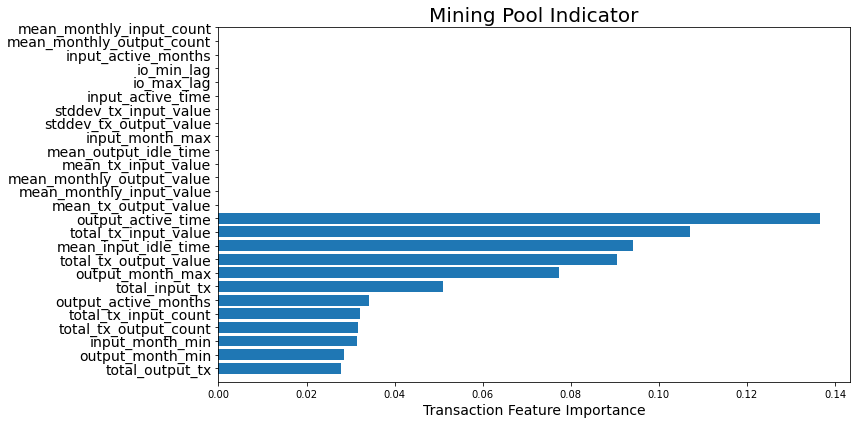

In [50]:
plot_feature_importance(btc_importances_ranked_top12, x_pos_2)

### Unknown Mining Pool Detection

**Definitions:**
* **Pooled Mining**: Pooled mining "pools" all of the resources of the clients in that pool to generate the solution to a given block. When the pool solves a block, the 6.25 BTC generated by that block's solution is split and distributed between the pools participants.

* **Solo Mining**: Solo mining is when a miner performs the mining operations alone without joining a pool. All mined blocks are generated to the miner's credit.

**Cause:** Unknown Mining Pools are **not** neccessarily one **coordinated private** pool. Rather, they could be a combination of solo miners and group miners that hide their pool

**Motivation:** Shadow mining may allow a group of miners to _hide their hash rate_ or _protect proprietary hardware_ (sub 5 nanometre ASIC chips)

**Result:** The lack of transparency poses a danger to the health of the bitcoin network as it may allow for game-theoretic attacks discussed later

Source: https://tinyurl.com/cfr632e

#### False positives from our confusion matrix can be attribtued to these unknown mining pools

---
> **Definition:**

> The Random Forest classifies **303** transactions from our test dataset, that show all the **tell-tale** signs of being mined by a Mining Pool but is not actually mined by a **Publicly Known Mining Pool Signature** 
_(as filtered out by the orginal Google BigQuery)_ i.e :

> * AntPool
> * BCMonster
> * BitMinter
> * Bravo Mining
> * BTCDig
> * Btcmp
> * BTC.com
> * BTCC Pool
> * btcZPool.com
> * BW Mining
> * Coinbase
> * Eligius
> * F2Pool
> * GHash.IO
> * Give Me COINS
> * Golden Nonce Pool
> * kmdPool.org
> * MergeMining
> * Merge Mining Pool
> * Multipool
> * P2Pool
> * Slush Pool
> * ZenPool.org


---

In [51]:
false_positives = (y_test == False) & (y_pred_rf_max_cpus == True)

Let's get the subset of test data rows only

In [52]:
test_dataframe = unpickled_dataframe.iloc[row_number_test, :]

Let's get the subset of false positives when model applied on the test set

In [53]:
test_dataframe.iloc[false_positives].head(3)  

,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
4382265,False,17EeH7G64avuSduKrbxkRXQ1JV7tKBhK6Y,1362096000,1498867200,1383264000,1501545600,136771200,118281600,-2678400,-21168000,...,23,286,10013213387.000000000,35011235.618881119,7.591097e+07,48,35011235.618881119,1.0,482009.290323,2.541812e+06
13820,False,1Aafyve8Z7giQxkyWQjMDZr4bzVWszf43k,1385856000,1454284800,1388534400,1417392000,68428800,28857600,36892800,-2678400,...,11,222,1922479859.000000000,8659819.184684685,7.291032e+06,51,8659819.184684685,1.0,300271.053812,6.146441e+05
592716,False,13xbaKsJtY5Uz4tktvUDA2h5vkXsKcy3vJ,1385856000,1467331200,1385856000,1462060800,81475200,76204800,5270400,0,...,13,165,1719395578.000000000,10420579.260606061,2.908096e+07,33,10420579.260606061,1.0,506841.745342,2.392638e+06


In [54]:
test_dataframe.iloc[false_positives].tail(3)

,is_miner,address,output_month_min,output_month_max,input_month_min,input_month_max,output_active_time,input_active_time,io_max_lag,io_min_lag,...,input_active_months,total_tx_input_count,total_tx_input_value,mean_tx_input_value,stddev_tx_input_value,total_input_tx,mean_monthly_input_value,mean_monthly_input_count,mean_output_idle_time,mean_input_idle_time
1647008,False,1PCzV7sABMtoBoD3wWGd7zfzAh55AtJ2hL,1401580800,1530403200,1406851200,1530403200,128822400,123552000,0,-5270400,...,8,154,1186155342.000000000,7702307.415584416,9.355534e+06,12,7702307.415584416,1.0,839157.130719,12566277.6
2721738,False,1GmXAk513KfanHY5cVqXLqkMTMHnNTh1e5,1385856000,1393632000,1385856000,1417392000,7776000,31536000,-23760000,0,...,2,42,173150356.000000000,4122627.523809524,2.190316e+06,6,4122627.523809524,1.0,208188.675000,6255864.0
2755176,False,17Mi9sFYX7xzZ5Latjqycf8V5TEKw1cRX9,1385856000,1396310400,1388534400,1396310400,10454400,7776000,0,-2678400,...,4,71,478848595.000000000,6744346.408450704,3.639180e+06,11,6744346.408450704,1.0,119729.342857,800590.6


In [55]:
def bitcoin_scatter(x, colors):
    num_classes = len(numpy.unique(colors))  # choose a color palette with seaborn.
    palette = numpy.array(seaborn.color_palette("hls", num_classes)) # create a scatter plot.
    f = matplotlib.pyplot.figure(figsize = (8, 8))
    ax = matplotlib.pyplot.subplot(aspect = 'equal')
    sc = ax.scatter(x[:,0], x[:,1], lw = 0, s = 40, c = palette[colors.astype(numpy.int)])
    matplotlib.pyplot.xlim(-25, 25)
    matplotlib.pyplot.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    matplotlib.pyplot.title('t-SNE to visualize features')
    txts = [] # add the labels for each digit corresponding to the label
    for i in range(num_classes):
        xtext, ytext = numpy.median(x[colors == i, :], axis = 0) # Position of each label at median of data points.
        txt = ax.text(xtext, ytext, str(i), fontsize = 24)
        txt.set_path_effects([
            matplotlib.patheffects.Stroke(linewidth = 5, foreground = "w"),
            matplotlib.patheffects.Normal()])
        txts.append(txt)
    return f, ax, sc, txts

#### The t-SNE dimensionality reduction for 26 features (of a bitcoin transaction) took 7.3 hours even when parallelized on 8 cores!

In [56]:
seaborn.set_style('darkgrid')
seaborn.set_palette('muted')
seaborn.set_context("notebook", font_scale = 1.5, rc = {"lines.linewidth": 2.5})
seed = 19
time_start2 = time.time()
bitcoin_tsne = TSNE(random_state = seed, n_jobs = -1).fit_transform(X)
print('Time elapsed: {} seconds' .format(time.time() - time_start2))

NameError: name 'seaborn' is not defined

In [57]:
bitcoin_scatter(bitcoin_tsne, y)

NameError: name 'bitcoin_tsne' is not defined